In [220]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [221]:
df = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("/Users/d.c.deh./Documents/Visual Studio/Data science 2/heart_statlog_cleveland_hungary_final.csv")

In [222]:
df.show(5)

+---+---+---------------+------------+-----------+-------------------+-----------+--------------+---------------+-------+--------+------+
|age|sex|chest pain type|resting bp s|cholesterol|fasting blood sugar|resting ecg|max heart rate|exercise angina|oldpeak|ST slope|target|
+---+---+---------------+------------+-----------+-------------------+-----------+--------------+---------------+-------+--------+------+
| 40|  1|              2|         140|        289|                  0|          0|           172|              0|    0.0|       1|     0|
| 49|  0|              3|         160|        180|                  0|          0|           156|              0|    1.0|       2|     1|
| 37|  1|              2|         130|        283|                  0|          1|            98|              0|    0.0|       1|     0|
| 48|  0|              4|         138|        214|                  0|          0|           108|              1|    1.5|       2|     1|
| 54|  1|              3|         

In [223]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- chest pain type: integer (nullable = true)
 |-- resting bp s: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- fasting blood sugar: integer (nullable = true)
 |-- resting ecg: integer (nullable = true)
 |-- max heart rate: integer (nullable = true)
 |-- exercise angina: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- ST slope: integer (nullable = true)
 |-- target: integer (nullable = true)



# Correlation

In [224]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# First putting all columns in a new column called features
assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
df_assembled = assembler.transform(df)

# Calculating the correlation matrix
correlation_matrix = Correlation.corr(df_assembled, "features").head()

In [225]:
print(correlation_matrix)

Row(pearson(features)=DenseMatrix(12, 12, [1.0, 0.0151, 0.1491, 0.2577, -0.0465, 0.1789, 0.1946, -0.3687, ..., -0.1984, 0.2167, 0.0731, -0.4133, 0.4815, 0.3984, 0.5056, 1.0], False))


([<matplotlib.axis.YTick at 0x176271250>,
 [Text(0, 0, 'age'),
  Text(0, 1, 'sex'),
  Text(0, 2, 'chest pain type'),
  Text(0, 3, 'resting bp s'),
  Text(0, 4, 'cholesterol'),
  Text(0, 5, 'fasting blood sugar'),
  Text(0, 6, 'resting ecg'),
  Text(0, 7, 'max heart rate'),
  Text(0, 8, 'exercise angina'),
  Text(0, 9, 'oldpeak'),
  Text(0, 10, 'ST slope'),
  Text(0, 11, 'target')])

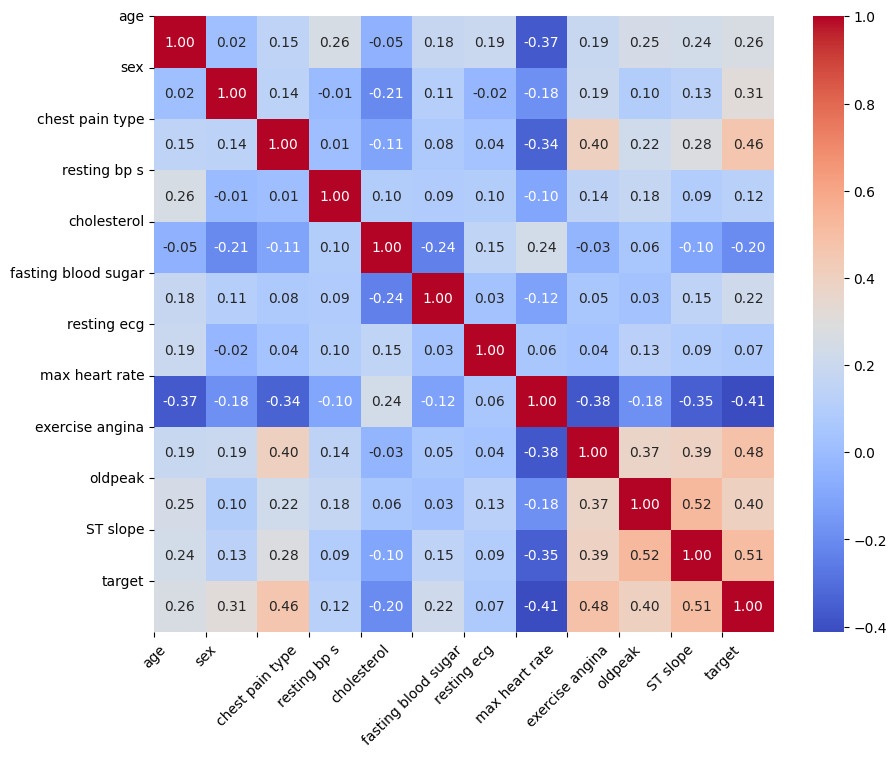

In [226]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Making it all look better cause the correlation matrix above is just a mess, I start by making an array of the matrix in preparation for the plot
corr_matrix_np = correlation_matrix[0].toArray()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_np, annot=True, cmap="coolwarm", fmt=".2f")
plt.xticks(ticks=np.arange(len(df.columns)), labels = df.columns, rotation=45)
plt.yticks(ticks=np.arange(len(df.columns)), labels = df.columns, rotation=0)

# Creating a model

In [227]:
# Creating a traintest split
train, test = df.randomSplit([0.7, 0.3], seed=100)
print(train.count())
print(test.count())

838
352


In [228]:
# Starting with all columns except for the target column
assemblerInputs = ["age", "sex", "chest pain type", "cholesterol", "fasting blood sugar", "resting ecg", "max heart rate", "exercise angina", "oldpeak", "ST slope"]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In [229]:
# Applying it to the training data
train = assembler.transform(train)
train = train.withColumnRenamed("target", "label")

In [230]:
# Applying it to the testing data
test = assembler.transform(test)
test = test.withColumnRenamed("target", "label")

In [231]:
from pyspark.ml.classification import LogisticRegression

# Defining the model
lr = LogisticRegression(featuresCol = "features", labelCol = "label", maxIter=10)

lrModel = lr.fit(train)

In [232]:
# Applying the test data on the model
predictions = lrModel.transform(test)
predictions.take(1)

[Row(age=29, sex=1, chest pain type=2, resting bp s=130, cholesterol=204, fasting blood sugar=0, resting ecg=2, max heart rate=202, exercise angina=0, oldpeak=0.0, ST slope=1, label=0, features=DenseVector([29.0, 1.0, 2.0, 204.0, 0.0, 2.0, 202.0, 0.0, 0.0, 1.0]), rawPrediction=DenseVector([3.1708, -3.1708]), probability=DenseVector([0.9597, 0.0403]), prediction=0.0)]

In [233]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Defining an evaluator for the model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")

# Using the evaluator to compute the accuracy
accuracy = evaluator.evaluate(predictions)

print("Accuracy:", accuracy)

Accuracy: 0.8380681818181818


In [234]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

In [235]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations

cvModel = cv.fit(train)

In [236]:
predictions = cvModel.transform(test)
accuracy = evaluator.evaluate(predictions)

print("Accuracy:", accuracy)

Accuracy: 0.8352272727272727


# Decision tree time

In [237]:
from pyspark.ml.classification import DecisionTreeClassifier

# Trying the same thing but with decisiontrees
dt = DecisionTreeClassifier(featuresCol = "features", labelCol = "label", maxDepth = 10)
dtModel = dt.fit(train)

In [238]:
predictions = dtModel.transform(test)
predictions.take(1)

[Row(age=29, sex=1, chest pain type=2, resting bp s=130, cholesterol=204, fasting blood sugar=0, resting ecg=2, max heart rate=202, exercise angina=0, oldpeak=0.0, ST slope=1, label=0, features=DenseVector([29.0, 1.0, 2.0, 204.0, 0.0, 2.0, 202.0, 0.0, 0.0, 1.0]), rawPrediction=DenseVector([109.0, 0.0]), probability=DenseVector([1.0, 0.0]), prediction=0.0)]

In [239]:
# Defining an evaluator for the model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")

# Using the evaluator to compute the accuracy
accuracy = evaluator.evaluate(predictions)

print("Accuracy:", accuracy)

Accuracy: 0.8892045454545454


In [240]:
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [1, 2, 6, 10])
             .addGrid(dt.maxBins, [20, 40, 80])
             .build())

In [241]:
cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations

cvModel = cv.fit(train)

In [242]:
predictions = cvModel.transform(test)
accuracy = evaluator.evaluate(predictions)

print("Accuracy:", accuracy)

Accuracy: 0.9034090909090909


# Random forest

In [243]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)

In [244]:
predictions = rfModel.transform(test)
predictions.take(1)

[Row(age=29, sex=1, chest pain type=2, resting bp s=130, cholesterol=204, fasting blood sugar=0, resting ecg=2, max heart rate=202, exercise angina=0, oldpeak=0.0, ST slope=1, label=0, features=DenseVector([29.0, 1.0, 2.0, 204.0, 0.0, 2.0, 202.0, 0.0, 0.0, 1.0]), rawPrediction=DenseVector([18.7054, 1.2946]), probability=DenseVector([0.9353, 0.0647]), prediction=0.0)]

In [245]:
# Defining an evaluator for the model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")

# Using the evaluator to compute the accuracy
accuracy = evaluator.evaluate(predictions)

print("Accuracy:", accuracy)

Accuracy: 0.8806818181818182


In [246]:
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [20, 60])
             .addGrid(rf.numTrees, [5, 20])
             .build())

# Creating a 5-fold CrossValidator
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)

In [247]:
predictions = cvModel.transform(test)
accuracy = evaluator.evaluate(predictions)

print("Accuracy:", accuracy)

Accuracy: 0.8806818181818182
